In [14]:

import capytaine as cpy
import matplotlib.pyplot as plt
import pygmsh
import gmsh
import numpy as np
import xarray as xr

f1 = .05
nfreq = 100
freq = np.linspace(f1,f1*nfreq,nfreq)

r1 = 0.88
r2 = 0.35
h1 = 0.17
h2 = 0.37
freeboard = .01

mesh_size_factor = .5

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    cyl = geom.add_cylinder([0, 0, 0],
                            [0, 0, -h1],
                            r1)
    cone = geom.add_cone([0, 0, -h1],
                            [0, 0, -h2],
                            r1, r2)
    geom.translate(cyl, [0, 0, freeboard])
    geom.translate(cone, [0, 0, freeboard])
    geom.boolean_union([cyl, cone])
    mesh = geom.generate_mesh()

# create mesh object from wavebot
from capytaine.io.meshio import load_from_meshio
mesh_obj = load_from_meshio(mesh, 'WaveBot')

lid_pos = mesh_obj.lowest_lid_position(omega_max=nfreq*f1*2*np.pi)
print(lid_pos)
#lid_pos = -.1 # overwrite lid position
lid_mesh = mesh_obj.generate_lid(lid_pos)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")

fb.center_of_mass = fb.center_of_buoyancy
fb.rotation_center = fb.center_of_mass

fb.keep_immersed_part()
#fb.show()

fb.add_translation_dof(name="Heave")

solver = cpy.BEMSolver()
test_matrix = xr.Dataset(coords={
    'rho': [1025],
    'water_depth': [np.infty],
    'omega': [ifreq*2*np.pi for ifreq in freq],
    'wave_direction': 0,
    'radiating_dof': list(fb.dofs.keys()),
    'g': [9.81],
})
wec_im = fb.copy(name=f"{fb.name}_immersed").keep_immersed_part()

bem_data = solver.fill_dataset(test_matrix, wec_im)

-0.008947526157057963


[15:00:33] WARNING  Mesh resolution for 146 problems:                                                              
                    The resolution of the mesh might be insufficient for omega ranging from 8.796 to 31.416.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()

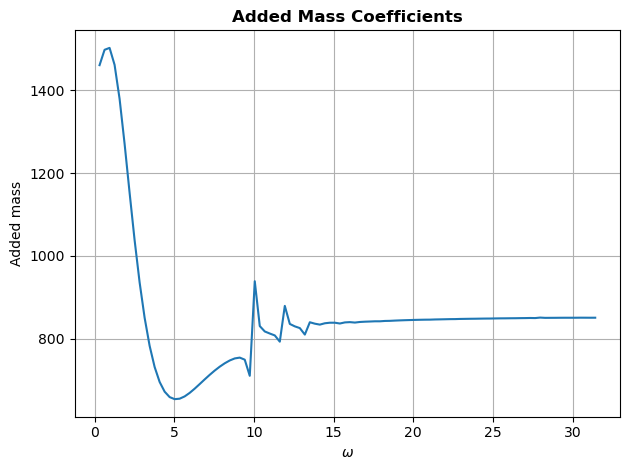

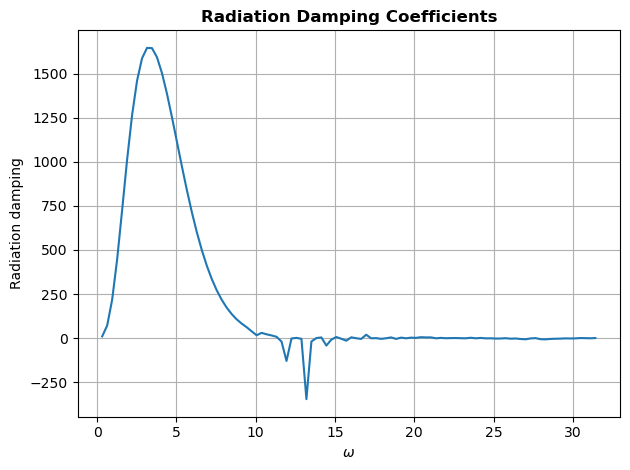

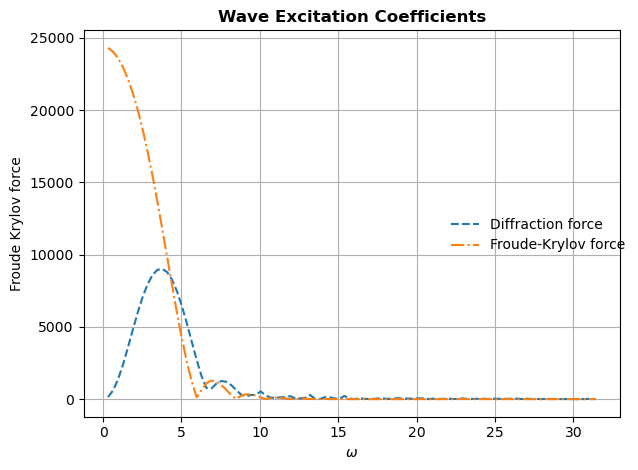

In [15]:
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Heave')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Heave')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
ax_ex.grid(True)
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Heave', influenced_dof='Heave').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')
ax_am.grid(True)

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Heave', influenced_dof='Heave').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')
ax_rd.grid(True)